In [1]:
options(max.print = 100)
filtered_erna_path = "Analysis/10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"
cell_type_enhancers_path = "Analysis/10X_PBMC/cell_type_enhancers/PBMC_enhancers_id.tsv"
cell_idents_path = "Analysis/10X_PBMC/gex_clustering/PBMC_RNA_idents.RDS"
enhancers_metadata_path = "Analysis/enhancers/tcea_FANTOM/tcea_FANTOM_enhancers_metadata.txt"


In [2]:
# Parameters
filtered_erna_path = "Analysis/10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"
cell_type_enhancers_path = "Analysis/10X_PBMC/cell_type_enhancers/PBMC_enhancers_id.tsv"
cell_idents_path = "Analysis/10X_PBMC/gex_clustering/PBMC_RNA_idents.RDS"
enhancers_metadata_path = "Analysis/enhancers/ensembl/ensembl_enhancers_metadata.txt"


In [3]:
setwd(here::here()) # set working directory to project root
getwd() 

[1] "/sci/labs/yotamd/lab_share/avishai.wizel/Projects/eRNA"

In [4]:
library(dplyr)
library(Matrix)
library(Seurat)
library(ggplot2)


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Attaching SeuratObject



‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed



In [5]:
rna_enhancers = readRDS(filtered_erna_path)

In [6]:
rna_enhancers[1:10,1:10]

  [[ suppressing 10 column names ‘AAACAGCCAAGGAATC’, ‘AAACAGCCAATCCCTT’, ‘AAACAGCCAATGCGCT’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                                 
ENSR10_73C2H3 . . . . . . . . . .
ENSR10_73PWXH . . . . . . . . . .
ENSR10_77L6BH . . . . . . . . . .
ENSR10_77ZG22 . . . . . . . . . .
ENSR10_783P86 . . . . . . . . . .
ENSR10_78LQB3 . . . . . . . . . .
ENSR10_78M49H . . . . . . . . . .
ENSR10_792D7X . . . . . . . . . .
ENSR10_79LLCR . . . . . . . . . .
ENSR10_7QRW5  . . . . . . . . . .

In [7]:
pbmc_erna = CreateSeuratObject(counts = rna_enhancers, project = "PBMC_eRNA", min.cells = 3, min.features = 3)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [8]:
pbmc_erna

An object of class Seurat 
29683 features across 11868 samples within 1 assay 
Active assay: RNA (29683 features, 0 variable features)

[1] "ENSR1-73W7G3"  "ENSR1-73FTGG"  "ENSR14-77TZB5" "ENSR6-7CS425" 
 [5] "ENSR3-7FJPD9"  "ENSR12-78HRZ3" "ENSR1-7HTGXW"  "ENSR2-85SCD9" 
 [9] "ENSR1-75RX2M"  "ENSR12-836BCK"

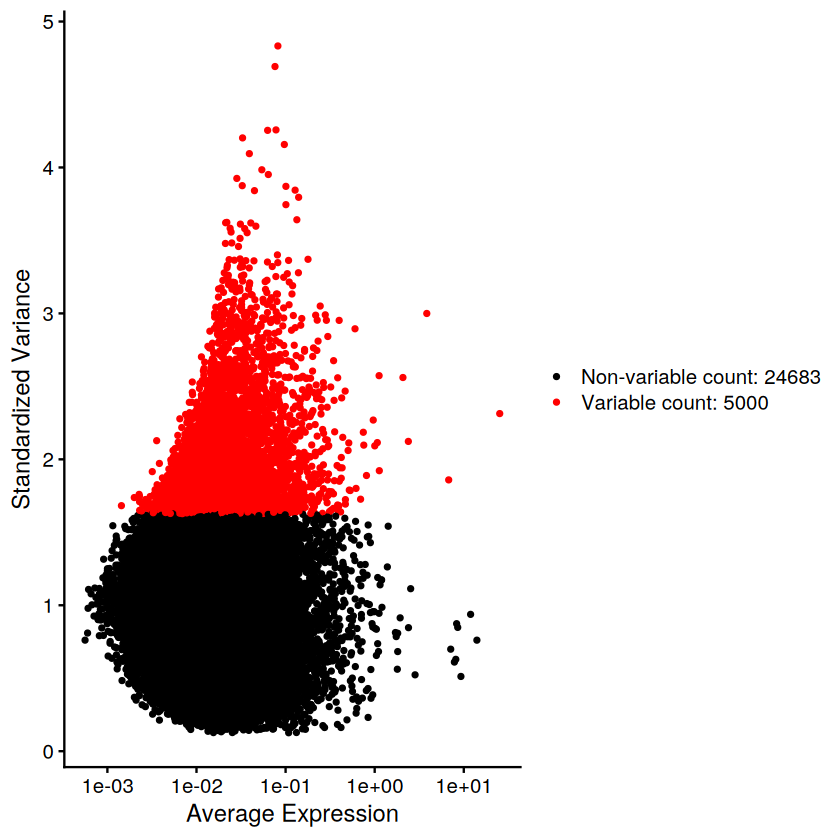

In [9]:

# Normalize and identify variable features
#pbmc_erna <- NormalizeData(pbmc_erna, normalization.method = "LogNormalize", scale.factor = 1e6)
pbmc_erna <- FindVariableFeatures(pbmc_erna, selection.method = "vst", nfeatures = 5000)

# Visualize variable features
top10 <- head(VariableFeatures(pbmc_erna), 10)
top10
VariableFeaturePlot(pbmc_erna)

Centering and scaling data matrix



PC_ 1 
Positive:  ENSR5-8442TN, ENSR5-844KZ4, ENSR5-843G2Z, ENSR1-87SWBH, ENSR16-8MT2F, ENSR8-88GMT, ENSR16-8M2Q6, ENSR5-83NDK6, ENSR8-748X82, ENSR16-8W2RL 
	   ENSR1-883QGL, ENSR4-84W9DB, ENSRX-853BCJ, ENSR2-84X4MH, ENSR1-85K985, ENSR8-8CX9F, ENSR1-869549, ENSR4-782SKD, ENSR7-84N9BZ, ENSR14-8WPDC 
	   ENSR4-7BZ3LM, ENSR7-8557ZK, ENSR8-84782S, ENSR2-8426PF, ENSR13-83GQ6C, ENSR2-88T6FR, ENSRX-83KHK6, ENSR3-86254D, ENSR17-84BJ9C, ENSR17-849H25 
Negative:  ENSR21-B3R6D, ENSR17-83G6HZ, ENSR6-78C72X, ENSR2-7H883M, ENSR4-856SLT, ENSR15-84WD59, ENSR19-7342FS, ENSR17-83FB9D, ENSR18-7NWG5, ENSR22-836NC2 
	   ENSR21-959G2, ENSR5-85XH2T, ENSR10-8M4B2, ENSR17-83XMJC, ENSR19-87TJB, ENSR3-767DD8, ENSR2-84ZRRG, ENSR5-876MKX, ENSR14-83RSJQ, ENSR13-93GBB4 
	   ENSR17-83F8X8, ENSR13-84WMJK, ENSR2-B3FD2Q, ENSR9-85D7NS, ENSR7-85SWR7, ENSRX-8S43G, ENSR17-83P33Q, ENSR11-83DQ6T, ENSR15-84WDN4, ENSR12-9GKKQ 
PC_ 2 
Positive:  ENSR5-843G2Z, ENSR5-8442TN, ENSR5-844KZ4, ENSR6-78C72X, ENSR4-856SLT, ENSR17-83G6HZ,

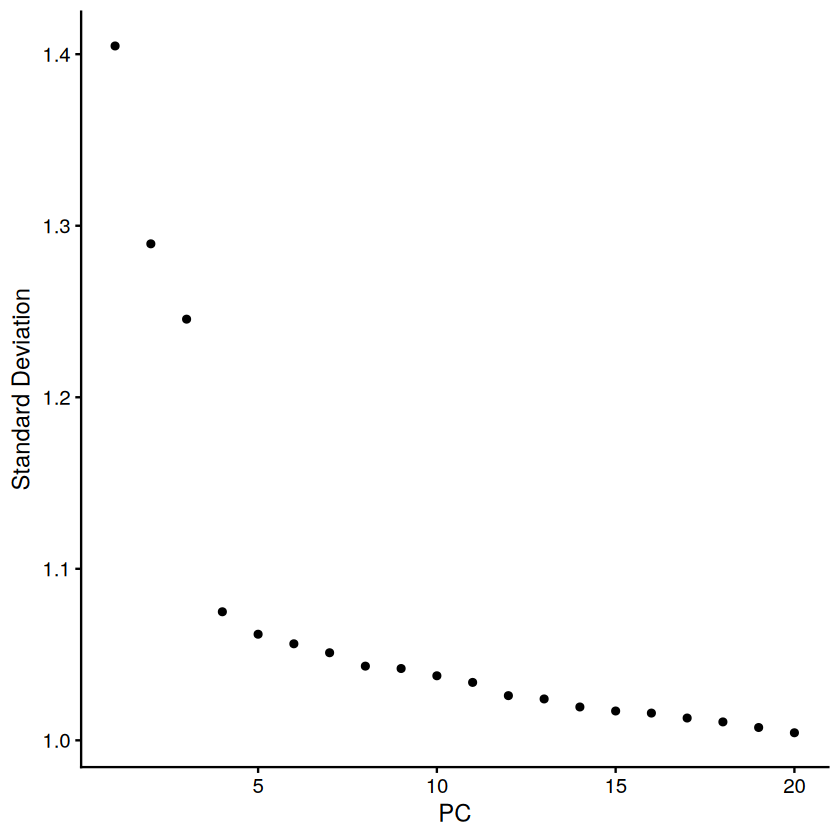

In [10]:
# Scale, PCA
pbmc_erna <- ScaleData(pbmc_erna, features = VariableFeatures(pbmc_erna))
pbmc_erna <- RunPCA(pbmc_erna, features = VariableFeatures(object = pbmc_erna))
ElbowPlot(pbmc_erna)



In [11]:
# Neighborhood graph, clustering and UMAP
pbmc_erna <- FindNeighbors(pbmc_erna, dims = 1:10)
pbmc_erna <- FindClusters(pbmc_erna, resolution = 0.2)



Computing nearest neighbor graph



Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11868
Number of edges: 353145

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8961
Number of communities: 11
Elapsed time: 3 seconds


In [12]:
pbmc_erna <- RunUMAP(pbmc_erna, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


19:30:22 UMAP embedding parameters a = 0.9922 b = 1.112



19:30:22 Read 11868 rows and found 10 numeric columns



19:30:22 Using Annoy for neighbor search, n_neighbors = 30



19:30:22 Building Annoy index with metric = cosine, n_trees = 50



0%   10   20   30   40   50   60   70   80   90   100%



[----|----|----|----|----|----|----|----|----|----|



*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


|



19:30:23 Writing NN index file to temp file /tmp/Rtmpdz0RVT/file19103e558673e9



19:30:23 Searching Annoy index using 1 thread, search_k = 3000



19:30:29 Annoy recall = 100%



19:30:30 Commencing smooth kNN distance calibration using 1 thread


 with target n_neighbors = 30



19:30:30 11 smooth knn distance failures



19:30:31 Initializing from normalized Laplacian + noise (using irlba)



19:30:31 Commencing optimization for 200 epochs, with 500282 positive edges



19:30:31 Using rng type: pcg



19:30:37 Optimization finished



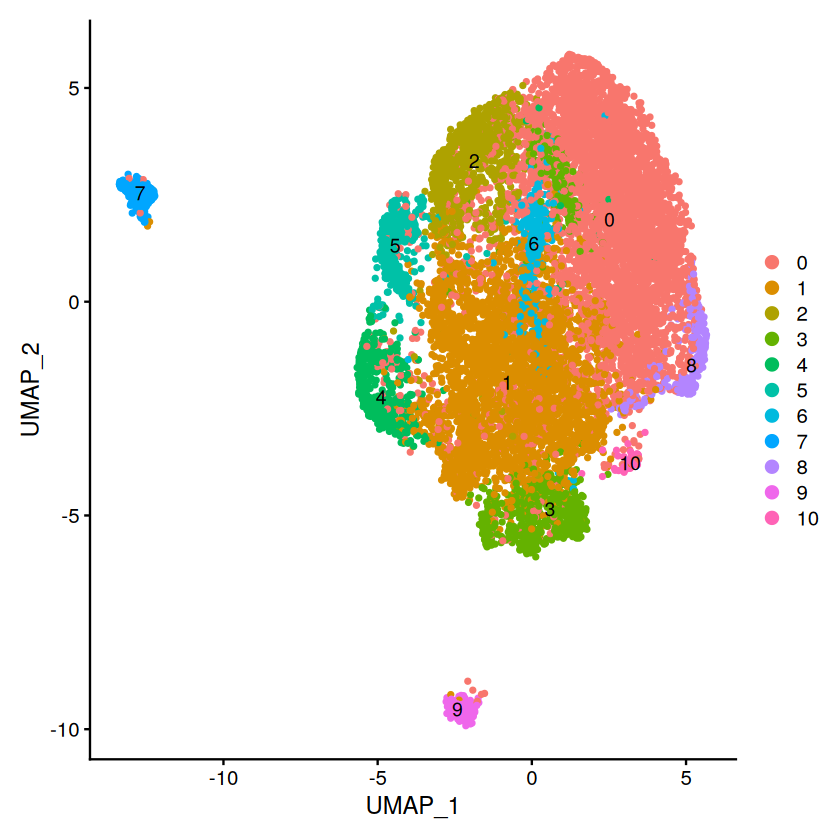

In [13]:
# Plot UMAP
DimPlot(pbmc_erna, reduction = "umap", label = TRUE,pt.size = 1) 

In [14]:
cell_type_idents = readRDS(cell_idents_path)
rownames(cell_type_idents) = gsub("-1","",rownames(cell_type_idents))
head(cell_type_idents)

,pbmc@active.ident
,<fct>
AAACAGCCAATCCCTT,cd4
AAACAGCCAATGCGCT,cd8
AAACAGCCACACTAAT,cd8
AAACAGCCACCAACCG,cd8
AAACAGCCAGGATAAC,cd4
AAACAGCCAGTTTACG,cd4


In [15]:
unique(cell_type_idents[1])

,pbmc@active.ident
,<fct>
AAACAGCCAATCCCTT,cd4
AAACAGCCAATGCGCT,cd8
AAACATGCACCGGCTA,undefined_t_cells
AAACCAACACAATGCC,cd14
AAACCGAAGCTGGACC,cd4_in_cd14
AAAGCAAGTTAACGGC,b_cells
AACAGATAGTAACCCG,cd4_near_b


In [16]:
pbmc_erna  = AddMetaData(object = pbmc_erna, metadata = cell_type_idents,col.name = "cell_type")

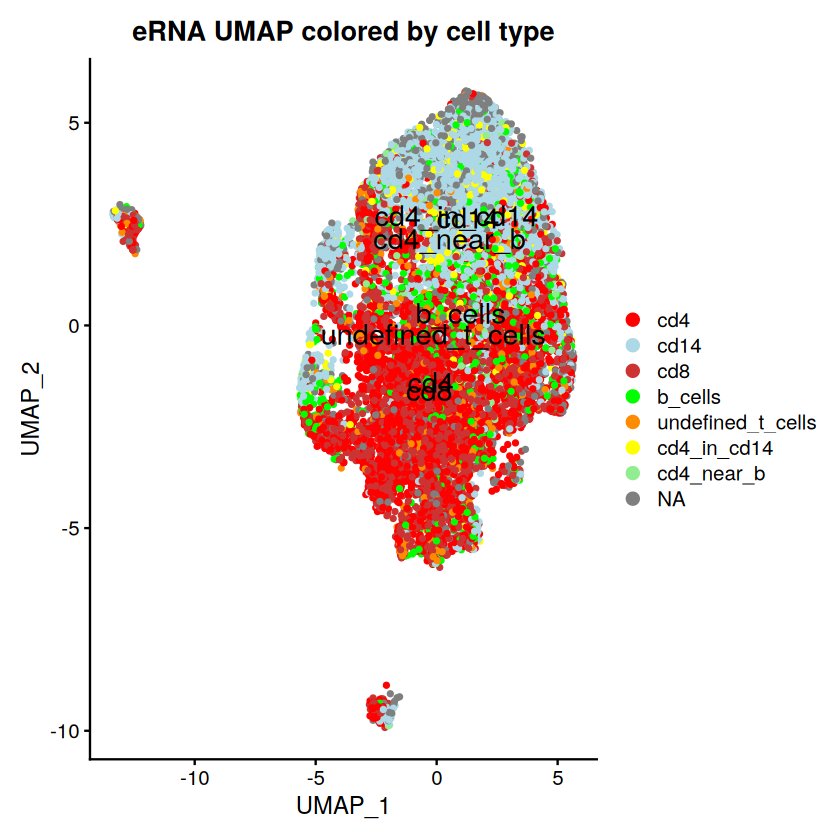

In [17]:
DimPlot(pbmc_erna, reduction = "umap", group.by = "cell_type", label = TRUE,pt.size = 1,label.size = 6)+ 
  ggtitle("eRNA UMAP colored by cell type")+
  #set colors
  scale_color_manual(values =c(
    "cd4" = "red",
    "cd8" = "brown3",
    "undefined_t_cells" = "darkorange",
    "cd4_in_cd14" = "yellow",
    "cd4_near_b" = "lightgreen",
    "b_cells" = "green",
    "cd14" = "lightblue",
    "other" = "gray"  # Add other cell types here if needed
))


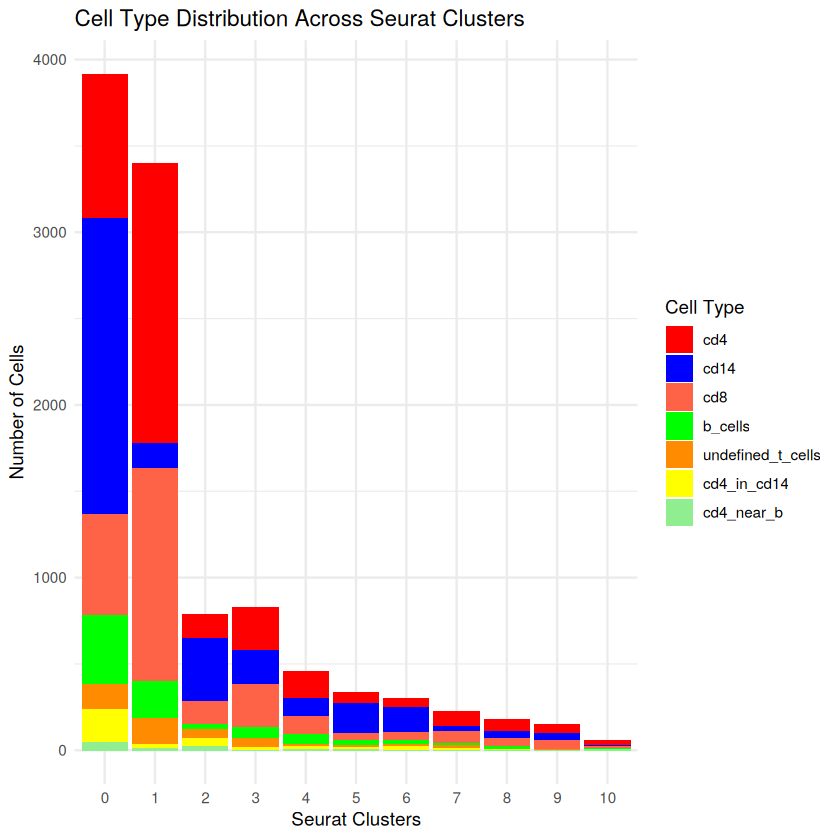

In [18]:
#stacked barplot of cell types per cluster
cluster_celltype_table = table(pbmc_erna$seurat_clusters, pbmc_erna$cell_type)
cluster_celltype_df = as.data.frame(cluster_celltype_table)

ggplot(cluster_celltype_df, aes(x=Var1, y=Freq, fill=Var2)) +
    geom_bar(stat="identity") +
    labs(x="Seurat Clusters", y="Number of Cells", fill="Cell Type") +
    ggtitle("Cell Type Distribution Across Seurat Clusters") +
    theme_minimal()+
    scale_fill_manual(values = c(
    "cd4" = "red",
    "cd8" = "tomato1",
    "undefined_t_cells" = "darkorange",
    "cd4_in_cd14" = "yellow",
    "cd4_near_b" = "lightgreen",
    "b_cells" = "green",
    "cd14" = "blue",
    "other" = "gray"  # Add other cell types here if needed
))

In [19]:
cluster_0_vs_cluster1_markers = FindMarkers(pbmc_erna, ident.1 = 0, ident.2 = 1, min.pct = 0)


For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



In [20]:
dim(cluster_0_vs_cluster1_markers)
head(cluster_0_vs_cluster1_markers,20)

[1] 23168     5

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSR21-CS28,5.394626e-238,36.3257418,0.916,0.810,1.601287e-233
ENSR5-D9GH7,1.477685e-231,8.1940402,0.486,0.134,4.386213e-227
ENSR21-DF3P,1.804134e-229,24.6623221,0.914,0.820,5.355212e-225
ENSR21-CSHH,4.567060e-228,10.2596848,0.908,0.808,1.355640e-223
ENSR6-78C72X,2.292047e-202,-406.9442574,0.027,0.242,6.803484e-198
ENSR21-B3N28,1.096515e-140,42.4495184,0.839,0.673,3.254787e-136
ENSR6-B4RND,3.394126e-137,26.4768925,0.277,0.058,1.007478e-132
ENSR5-B34SXH,6.172770e-136,7.2904793,0.272,0.056,1.832263e-131
ENSR21-B3M2Q,2.191720e-130,60.3287266,0.833,0.674,6.505681e-126


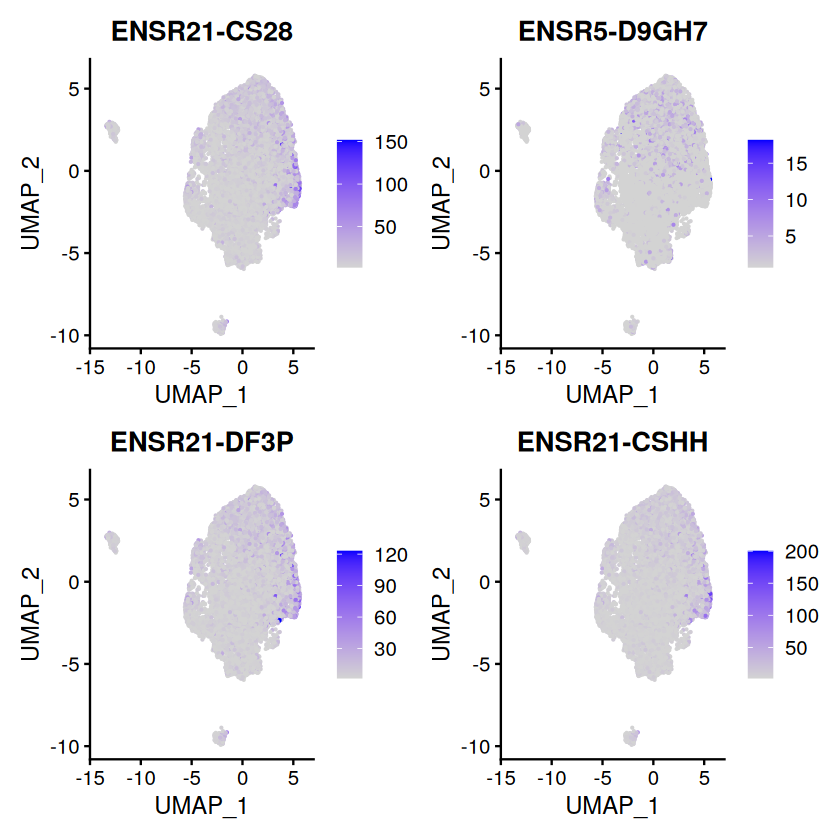

In [21]:
FeaturePlot(pbmc_erna, features = rownames(cluster_0_vs_cluster1_markers)[1:4], min.cutoff = "q9")

In [22]:
top_de_enhancers = rownames(head(cluster_0_vs_cluster1_markers,20)) %>% gsub("-","_",.)
top_de_enhancers

[1] "ENSR21_CS28"  "ENSR5_D9GH7"  "ENSR21_DF3P"  "ENSR21_CSHH"  "ENSR6_78C72X"
 [6] "ENSR21_B3N28" "ENSR6_B4RND"  "ENSR5_B34SXH" "ENSR21_B3M2Q" "ENSR9_C98ZW" 
[11] "ENSR21_B3M95" "ENSR6_B4RN5"  "ENSR17_D45XB" "ENSR7_855D25" "ENSR4_856SLT"
[16] "ENSR10_C8T4T" "ENSR2_C625T"  "ENSR10_BHP86" "ENSR8_C7K26"  "ENSR7_847MWW"

In [23]:
enhancers_metadata <- data.table::fread(enhancers_metadata_path, header = T, sep = "\t", data.table = FALSE)

In [24]:
enhancers_metadata

chr,start,end,id,type,gene_intersection,bp_to_closest_gene,length
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,11436,11649,ENSR1_88N,1,intergenic,53770,213
1,12685,14671,ENSR1_CZ,1,intergenic,50748,1986
1,15100,15853,ENSR1_B48,1,intergenic,49566,753
1,21128,21603,ENSR1_986,1,intergenic,43816,475
1,25830,26342,ENSR1_B5Q,1,intergenic,39077,512
1,28599,29332,ENSR1_B67,1,intergenic,36087,733
1,30539,30813,ENSR1_9BT,1,intergenic,34606,274
1,31906,32843,ENSR1_B6N,1,intergenic,32576,937
1,34247,35149,ENSR1_B72,1,intergenic,30270,902


In [25]:
# deg = cluster_0_vs_cluster1_markers %>% filter(p_val_adj < 0.05 & abs(avg_log2FC) > 2)
# enhancers_metadata$id = gsub("_","-",enhancers_metadata$id)
# rownames(enhancers_metadata) = enhancers_metadata$id
# #barplot how many are intergenic or intragenic
# deg_metadata = enhancers_metadata[match(rownames(deg), enhancers_metadata$id), ]
# table(deg_metadata$gene_intersection )